# Qwen3-VL Training on RefCOCO

This notebook trains Qwen3-VL-2B-Instruct with LoRA on the RefCOCO phrase grounding dataset.

**Benefits of using this notebook:**
- Run cells independently to control resource usage
- Monitor GPU/CPU temperature between steps
- Adjust batch size and training parameters interactively
- Stop training anytime without losing progress

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import yaml
import torch

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.common.device import get_device, get_device_name
from src.common.paths import ProjectPaths
from src.data.refcoco_dataset import create_refcoco_dataloader
from src.pipeline.model_qwen3 import load_qwen3_vl_with_lora
from src.pipeline.training import Trainer

print("✓ Imports successful")
print(f"Project root: {project_root}")

✓ Imports successful
Project root: /Users/pscs/pprojects/vlm-bounding-box


## 2. Configuration

**Adjust these parameters to control resource usage:**
- `batch_size`: Lower = less memory/heat (start with 1-2)
- `max_train_samples`: Limit training data for faster iterations
- `num_epochs`: Number of passes through the data
- `gradient_accumulation_steps`: Simulate larger batches (reduce heat per step)

In [2]:
# ============================================
# TRAINING PARAMETERS - Adjust as needed
# ============================================

# Data parameters
BATCH_SIZE = 1  # Start small! Increase if your system can handle it
MAX_TRAIN_SAMPLES = 200  # Limit samples for faster experimentation
MAX_VAL_SAMPLES = 100
NUM_WORKERS = 0  # Set to 0 to reduce CPU load

# Training parameters
NUM_EPOCHS = 4  # Start with 1 epoch
LEARNING_RATE = 2e-4
GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch = BATCH_SIZE * this value
MAX_GRAD_NORM = 1.0
WARMUP_STEPS = 100

# LoRA parameters
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05

# Logging
LOGGING_STEPS = 10
EVAL_STEPS = 100
SAVE_STEPS = 200

# Device
PREFER_CUDA = False  # Set True for CUDA, False for MPS/CPU

# Paths
OUTPUT_DIR = project_root / "outputs" / "qwen3_refcoco"
LOG_DIR = project_root / "logs"

print("✓ Configuration set")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max train samples: {MAX_TRAIN_SAMPLES}")
print(f"  Effective batch: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

✓ Configuration set
  Batch size: 1
  Max train samples: 200
  Effective batch: 4


## 3. Device Setup

In [3]:
# Get available device
device = get_device(prefer_cuda=PREFER_CUDA)
device_name = get_device_name(prefer_cuda=PREFER_CUDA)

print(f"Using device: {device_name}")
print(f"Device type: {device.type}")

# Setup project paths
paths = ProjectPaths()
paths.create_directories()
print("✓ Directories created")

Using device: MPS (Apple Silicon)
Device type: mps
✓ Directories created


## 4. Load Model

**This will download and load the Qwen3-VL model with LoRA adapters.**

Note: The model is ~4GB and will use system memory.

In [4]:
print("Loading Qwen3-VL-2B-Instruct model with LoRA...")
print("This may take a few minutes on first run...\n")

model, processor = load_qwen3_vl_with_lora(
    model_name="Qwen/Qwen3-VL-2B-Instruct",
    use_quantization=False,  # Quantization not well supported on MPS
    lora_r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    device=str(device)
)

print("\n✓ Model loaded successfully")

Loading Qwen3-VL-2B-Instruct model with LoRA...
This may take a few minutes on first run...

Loading Qwen3-VL model: Qwen/Qwen3-VL-2B-Instruct
Device: mps
Quantization: False (4-bit)
LoRA config: r=16, alpha=32, dropout=0.05


`torch_dtype` is deprecated! Use `dtype` instead!


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
trainable params: 6,422,528 || all params: 2,133,954,560 || trainable%: 0.3010

Model loaded successfully on mps
Model type: <class 'peft.peft_model.PeftModelForCausalLM'>

✓ Model loaded successfully


/Users/pscs/pprojects/vlm-bounding-box/.venv/lib/python3.13/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


## 4b. Check Resource Usage

**Review these metrics before training to ensure your system can handle it:**
- Model memory footprint
- Parameter counts (trainable vs frozen)
- Estimated training memory requirements

In [5]:
import psutil
import os

print("=" * 60)
print("RESOURCE USAGE ANALYSIS")
print("=" * 60)

# 1. Model Parameters
print("\n📊 MODEL PARAMETERS:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"  Total parameters:     {total_params:,} ({total_params/1e9:.2f}B)")
print(f"  Trainable (LoRA):     {trainable_params:,} ({trainable_params/1e6:.2f}M)")
print(f"  Frozen (base model):  {frozen_params:,} ({frozen_params/1e9:.2f}B)")
print(f"  Trainable %:          {100 * trainable_params / total_params:.2f}%")

# 2. Model Memory Footprint
print("\n💾 MODEL MEMORY FOOTPRINT:")
model_memory_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
model_memory_gb = model_memory_bytes / (1024**3)
print(f"  Model weights:        {model_memory_gb:.2f} GB")

# 3. Training Memory Estimate
print("\n🔥 ESTIMATED TRAINING MEMORY:")
# AdamW optimizer stores: parameters + 2 copies for momentum/variance (only for trainable params)
trainable_memory_bytes = sum(p.numel() * p.element_size() for p in model.parameters() if p.requires_grad)
optimizer_memory_bytes = trainable_memory_bytes * 2  # momentum + variance
gradient_memory_bytes = trainable_memory_bytes  # gradients

total_training_memory_gb = (model_memory_bytes + optimizer_memory_bytes + gradient_memory_bytes) / (1024**3)

print(f"  Model:                {model_memory_gb:.2f} GB")
print(f"  Optimizer states:     {optimizer_memory_bytes / (1024**3):.2f} GB")
print(f"  Gradients:            {gradient_memory_bytes / (1024**3):.2f} GB")
print(f"  ─────────────────────────────")
print(f"  TOTAL (estimated):    {total_training_memory_gb:.2f} GB")

# 4. Per-batch Memory Estimate
print("\n📦 PER-BATCH ESTIMATES:")
# Rough estimate: activations are ~2-3x model size per sample for transformers
activation_per_sample_gb = model_memory_gb * 2.5
activation_total_gb = activation_per_sample_gb * BATCH_SIZE
effective_batch = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

print(f"  Batch size:           {BATCH_SIZE}")
print(f"  Gradient accum steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  Effective batch:      {effective_batch}")
print(f"  Activation memory:    ~{activation_total_gb:.2f} GB per forward pass")

# 5. System Memory
print("\n🖥️  SYSTEM MEMORY:")
mem = psutil.virtual_memory()
mem_total_gb = mem.total / (1024**3)
mem_available_gb = mem.available / (1024**3)
mem_used_gb = mem.used / (1024**3)
mem_percent = mem.percent

print(f"  Total RAM:            {mem_total_gb:.2f} GB")
print(f"  Used RAM:             {mem_used_gb:.2f} GB ({mem_percent:.1f}%)")
print(f"  Available RAM:        {mem_available_gb:.2f} GB")

# 6. Training Feasibility Check
print("\n✅ FEASIBILITY CHECK:")
memory_needed = total_training_memory_gb + activation_total_gb
memory_margin = mem_available_gb - memory_needed

if memory_margin > 5:
    status = "✅ GOOD - Plenty of headroom"
    color = "green"
elif memory_margin > 2:
    status = "⚠️  CAUTION - Limited headroom, monitor closely"
    color = "yellow"
else:
    status = "❌ RISKY - May run out of memory or cause heavy swapping"
    color = "red"

print(f"  Memory needed:        ~{memory_needed:.2f} GB")
print(f"  Available:            {mem_available_gb:.2f} GB")
print(f"  Margin:               {memory_margin:.2f} GB")
print(f"  Status:               {status}")

print("\n" + "=" * 60)
print("💡 TIP: If memory is tight, try reducing BATCH_SIZE or")
print("    MAX_TRAIN_SAMPLES in cell 2 (Configuration)")
print("=" * 60)

RESOURCE USAGE ANALYSIS

📊 MODEL PARAMETERS:
  Total parameters:     2,133,954,560 (2.13B)
  Trainable (LoRA):     6,422,528 (6.42M)
  Frozen (base model):  2,127,532,032 (2.13B)
  Trainable %:          0.30%

💾 MODEL MEMORY FOOTPRINT:
  Model weights:        7.95 GB

🔥 ESTIMATED TRAINING MEMORY:
  Model:                7.95 GB
  Optimizer states:     0.05 GB
  Gradients:            0.02 GB
  ─────────────────────────────
  TOTAL (estimated):    8.02 GB

📦 PER-BATCH ESTIMATES:
  Batch size:           1
  Gradient accum steps: 4
  Effective batch:      4
  Activation memory:    ~19.87 GB per forward pass

🖥️  SYSTEM MEMORY:
  Total RAM:            36.00 GB
  Used RAM:             19.51 GB (75.0%)
  Available RAM:        9.01 GB

✅ FEASIBILITY CHECK:
  Memory needed:        ~27.90 GB
  Available:            9.01 GB
  Margin:               -18.89 GB
  Status:               ❌ RISKY - May run out of memory or cause heavy swapping

💡 TIP: If memory is tight, try reducing BATCH_SIZE or
    MA

## 5. Load RefCOCO Dataset

**Note:** RefCOCO uses 'val' split for training and 'test' split for evaluation.

In [6]:
def collate_fn(batch):
    """Custom collate function for batching."""
    collated = {}
    for key in batch[0].keys():
        collated[key] = [item[key] for item in batch]
    return collated


print("Loading RefCOCO dataset...")

train_loader = create_refcoco_dataloader(
    split="val",  # Training data
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    max_samples=MAX_TRAIN_SAMPLES,
    collate_fn=collate_fn,
    device=device.type
)

val_loader = create_refcoco_dataloader(
    split="test",  # Validation data
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    max_samples=MAX_VAL_SAMPLES,
    collate_fn=collate_fn,
    device=device.type
)

print(f"✓ Dataset loaded")
print(f"  Train samples: {len(train_loader.dataset)}")
print(f"  Val samples: {len(val_loader.dataset)}")
print(f"  Train batches: {len(train_loader)}")

Loading RefCOCO dataset...

Loading RefCOCO dataset: lmms-lab/RefCOCO
  Split: val
  Variant: refcoco
  Max samples: 200
Loaded 200 samples

Loading RefCOCO dataset: lmms-lab/RefCOCO
  Split: test
  Variant: refcoco
  Max samples: 100
Loaded 100 samples
✓ Dataset loaded
  Train samples: 200
  Val samples: 100
  Train batches: 200


## 6. Inspect Sample Data (Optional)

View a sample from the dataset to verify everything loaded correctly.

In [7]:
# Get one batch
sample_batch = next(iter(train_loader))

print("Sample batch keys:", sample_batch.keys())
print(f"Batch size: {len(sample_batch['image'])}")
print(f"\nFirst sample:")
print(f"  Phrase: {sample_batch['phrase'][0]}")
print(f"  Image size: {sample_batch['width'][0]} x {sample_batch['height'][0]}")
print(f"  Normalized bbox: {sample_batch['bbox_norm'][0]}")
print(f"  Bbox JSON: {sample_batch['bbox_json'][0]}")

Sample batch keys: dict_keys(['image', 'width', 'height', 'phrase', 'bbox_norm', 'bbox_json'])
Batch size: 1

First sample:
  Phrase: Please carefully observe the area circled in the image and come up with a caption for the area.
  Image size: 640 x 480
  Normalized bbox: (0.09353125095367432, 0.44902083079020183, 0.4852968692779541, 0.964312489827474)
  Bbox JSON: {"x_max":0.4853,"x_min":0.0935,"y_max":0.9643,"y_min":0.449}


## 7. Initialize Trainer

In [8]:
print("Initializing trainer...")

trainer = Trainer(
    model=model,
    processor=processor,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    warmup_steps=WARMUP_STEPS,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    max_grad_norm=MAX_GRAD_NORM,
    device=str(device),
    output_dir=OUTPUT_DIR,
    log_dir=LOG_DIR,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    save_steps=SAVE_STEPS,
)

print("✓ Trainer initialized")

Initializing trainer...

Trainer initialized:
  Device: mps
  Total epochs: 4
  Steps per epoch: 200
  Total training steps: 200
  Warmup steps: 100
  Learning rate: 0.0002
  Gradient accumulation: 4
✓ Trainer initialized


## 8. Start Training

**⚠️ Resource Warning:**
- This cell will use significant CPU/GPU resources
- Monitor your system temperature
- You can interrupt the cell (Ctrl+C in terminal or stop button in IDE) to pause training
- Checkpoints are saved every `SAVE_STEPS` steps

**Tips to reduce heat:**
- Lower `BATCH_SIZE` to 1
- Increase `GRADIENT_ACCUMULATION_STEPS`
- Reduce `MAX_TRAIN_SAMPLES`
- Set `NUM_WORKERS = 0`

In [9]:
print("Starting training...")
print(f"Config: {NUM_EPOCHS} epoch(s), {len(train_loader)} batches per epoch\n")

try:
    trainer.train()
    print("\n✓ Training complete!")
except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user")
    print("Checkpoints are saved in:", OUTPUT_DIR)

Starting training...
Config: 4 epoch(s), 200 batches per epoch


Starting training...


Epoch 1/4: 100%|██████████| 200/200 [02:56<00:00,  1.13it/s, loss=1.1172, lr=1.00e-04]



Epoch 1 completed. Average loss: 1.1172


Evaluating: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Validation Loss: 0.7524
Checkpoint saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/epoch_1


Epoch 2/4: 100%|██████████| 200/200 [04:36<00:00,  1.38s/it, loss=0.7131, lr=2.00e-04]



Validation Loss: 0.6601

Epoch 2 completed. Average loss: 0.7131


Evaluating: 100%|██████████| 100/100 [01:03<00:00,  1.56it/s]



Validation Loss: 0.6601
Checkpoint saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/epoch_2


Epoch 3/4: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it, loss=0.6613, lr=1.00e-04]



Epoch 3 completed. Average loss: 0.6613


Evaluating: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]



Validation Loss: 0.6482
Checkpoint saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/epoch_3


Evaluating: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]loss=0.6163, lr=0.00e+00]



Validation Loss: 0.6278


Epoch 4/4: 100%|██████████| 200/200 [04:09<00:00,  1.25s/it, loss=0.6163, lr=0.00e+00]


Checkpoint saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/step_200

Epoch 4 completed. Average loss: 0.6163


Evaluating: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]



Validation Loss: 0.6278
Checkpoint saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/epoch_4

Training completed!
Total time: 19.44 minutes
Checkpoint saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/final
Training history saved to /Users/pscs/pprojects/vlm-bounding-box/logs/training_history.json

✓ Training complete!


## 9. Save Final Model

In [13]:
from src.pipeline.model_qwen3 import save_lora_weights

# Save LoRA weights
final_output = OUTPUT_DIR / "final_lora_weights"
save_lora_weights(model, str(final_output))

print(f"✓ Final LoRA weights saved to: {final_output}")

LoRA weights saved to /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/final_lora_weights
✓ Final LoRA weights saved to: /Users/pscs/pprojects/vlm-bounding-box/outputs/qwen3_refcoco/final_lora_weights


## 9b. 🔍 Debugging: Training Data Inspection

**⚠️ DIAGNOSTIC SECTION - Run this to understand training issues**

This section helps debug why the trained model might perform poorly by showing:
1. How training data is tokenized and masked
2. What the model is actually being trained to predict
3. Whether label masking is correct

In [14]:
print("=" * 70)
print("TRAINING DATA INSPECTION")
print("=" * 70)

# Get one training sample
train_batch = next(iter(train_loader))

print(f"\n📦 Inspecting batch with {len(train_batch['image'])} sample(s)")
print(f"  Image shape: {train_batch['image'][0].size}")
print(f"  Phrase: '{train_batch['phrase'][0][:60]}...'")
print(f"  Target bbox: {train_batch['bbox_json'][0]}")

# Recreate what trainer.prepare_batch() does
from src.pipeline.prompts import build_grounding_prompt

sample_image = train_batch['image'][0]
sample_phrase = train_batch['phrase'][0]
sample_bbox_json = train_batch['bbox_json'][0]

# Build the prompt
prompt = build_grounding_prompt(sample_phrase)

print(f"\n📝 Prompt used:")
print(f"  {prompt[:100]}...")

# Format as conversation (same as training)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": sample_image},
            {"type": "text", "text": prompt}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": sample_bbox_json}
        ]
    }
]

# Apply chat template (as in training)
text = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=False
)

print(f"\n📄 Full conversation text:")
print(f"  Length: {len(text)} characters")
print(f"  Preview: {text[:200]}...")

# Tokenize
inputs = processor(
    text=[text],
    images=[sample_image],
    return_tensors="pt",
    padding=True
)

print(f"\n🔢 Tokenization:")
print(f"  Input IDs shape: {inputs['input_ids'].shape}")
print(f"  Total tokens: {inputs['input_ids'].shape[1]}")

# Check what the CURRENT masking does (from training.py lines 196-202)
print(f"\n⚠️  CURRENT MASKING LOGIC (BUGGY):")
prompt_only = processor.apply_chat_template(
    [{"role": "user", "content": [{"type": "text", "text": prompt}]}],
    tokenize=True,
    add_generation_prompt=True
)
buggy_prompt_length = len(prompt_only)
print(f"  Calculated prompt length: {buggy_prompt_length} tokens")
print(f"  This means tokens 0-{buggy_prompt_length} would be masked")
print(f"  Tokens {buggy_prompt_length}-{inputs['input_ids'].shape[1]} would be trained on")

# Decode to see what's being masked vs trained
print(f"\n🔍 What tokens are in each section:")
input_ids = inputs['input_ids'][0]

# First 50 tokens
print(f"\n  First 50 tokens (should be prompt + image):")
first_tokens = processor.tokenizer.decode(input_ids[:50], skip_special_tokens=False)
print(f"  {first_tokens[:200]}...")

# Around the "mask boundary"
if buggy_prompt_length < len(input_ids):
    print(f"\n  Around mask boundary (tokens {max(0, buggy_prompt_length-10)}-{min(len(input_ids), buggy_prompt_length+20)}):")
    boundary_tokens = processor.tokenizer.decode(
        input_ids[max(0, buggy_prompt_length-10):min(len(input_ids), buggy_prompt_length+20)], 
        skip_special_tokens=False
    )
    print(f"  {boundary_tokens}")

# Last 50 tokens (should be bbox)
print(f"\n  Last 50 tokens (should be assistant bbox response):")
last_tokens = processor.tokenizer.decode(input_ids[-50:], skip_special_tokens=False)
print(f"  {last_tokens}")

print(f"\n" + "=" * 70)
print("❌ PROBLEM IDENTIFIED:")
print("The masking calculation doesn't account for:")
print("  1. Vision tokens from the image (~100-500 tokens)")
print("  2. Different tokenization with/without assistant message")
print("  3. Actual position of assistant response in full sequence")
print(f"\nThis means the model is training on WRONG tokens!")
print("=" * 70)

TRAINING DATA INSPECTION

📦 Inspecting batch with 1 sample(s)
  Image shape: (480, 640)
  Phrase: 'Please carefully observe the area circled in the image and c...'
  Target bbox: {"x_max":0.8821,"x_min":0.3358,"y_max":1.0,"y_min":0.7472}

📝 Prompt used:
  You are a vision assistant. I will give you an image and a short description that refers to exactly ...

📄 Full conversation text:
  Length: 646 characters
  Preview: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>You are a vision assistant. I will give you an image and a short description that refers to exactly one object or region in the image.

Desc...

🔢 Tokenization:
  Input IDs shape: torch.Size([1, 457])
  Total tokens: 457

⚠️  CURRENT MASKING LOGIC (BUGGY):
  Calculated prompt length: 1 tokens
  This means tokens 0-1 would be masked
  Tokens 1-457 would be trained on

🔍 What tokens are in each section:

  First 50 tokens (should be prompt + image):
  <|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|im

### Compare Raw Model Outputs

See what the base vs trained models are actually generating.

In [15]:
print("=" * 70)
print("RAW OUTPUT COMPARISON")
print("=" * 70)

# Show raw responses from the evaluation
print(f"\n📊 Analysis of {len(base_model_metrics['results'])} predictions:\\n")

print("🔵 BASE MODEL outputs:")
base_successful = 0
base_failed = 0
base_output_samples = []

for i, result in enumerate(base_model_metrics['results'][:5]):  # Show first 5
    status = "✓" if result['success'] else "❌"
    print(f"\n  Sample {i} {status}:")
    print(f"    Raw: '{result['raw_response'][:150]}...'")
    if result['success']:
        print(f"    Parsed bbox: {result['predicted_bbox']}")
        base_successful += 1
    else:
        base_failed += 1
        
print(f"\n  Summary: {base_successful} successful, {base_failed} failed")

print(f"\n{'='*70}")
print("🟢 TRAINED MODEL outputs:")
trained_successful = 0
trained_failed = 0

# Check if trained_results exists from previous eval
if 'trained_results' in locals():
    for i, result in enumerate(trained_results[:5]):  # Show first 5
        status = "✓" if result['success'] else "❌"
        print(f"\n  Sample {i} {status}:")
        print(f"    Raw: '{result['raw_response'][:150]}...'")
        if result['success']:
            print(f"    Parsed bbox: {result['predicted_bbox']}")
            trained_successful += 1
        else:
            trained_failed += 1
            
    print(f"\n  Summary: {trained_successful} successful, {trained_failed} failed")
    
    # Analysis
    print(f"\n{'='*70}")
    print("🔍 ANALYSIS:")
    print(f"\n  Base model outputs look like:")
    base_sample = base_model_metrics['results'][0]['raw_response']
    if '{' in base_sample and '}' in base_sample:
        print(f"    ✓ Valid JSON format")
    else:
        print(f"    ❌ Not JSON format")
    
    print(f"\n  Trained model outputs look like:")
    trained_sample = trained_results[0]['raw_response']
    if '{' in trained_sample and '}' in trained_sample:
        print(f"    ✓ Contains JSON-like structure")
    else:
        print(f"    ❌ Not JSON format")
    
    # Count how many have valid JSON structure
    base_has_json = sum(1 for r in base_model_metrics['results'] if '{' in r['raw_response'] and '}' in r['raw_response'])
    trained_has_json = sum(1 for r in trained_results if '{' in r['raw_response'] and '}' in r['raw_response'])
    
    print(f"\n  Outputs containing '{{' and '}}' braces:")
    print(f"    Base: {base_has_json}/{len(base_model_metrics['results'])} ({base_has_json/len(base_model_metrics['results'])*100:.0f}%)")
    print(f"    Trained: {trained_has_json}/{len(trained_results)} ({trained_has_json/len(trained_results)*100:.0f}%)")
    
    if trained_has_json < base_has_json:
        print(f"\n  ❌ PROBLEM: Trained model generates fewer JSON-like outputs!")
        print(f"     This confirms the model learned WRONG output format.")
else:
    print("  ⚠️ Run evaluation cells first to see trained model outputs")

print("=" * 70)

RAW OUTPUT COMPARISON


NameError: name 'base_model_metrics' is not defined

## 10. Evaluation: Base vs Trained Model

**This section evaluates and compares both models on the same test samples.**

We'll run evaluation in 3 steps:
1. **Sample test data** (with fixed seed for reproducibility)
2. **Evaluate base model** (untrained)
3. **Evaluate trained model** (your fine-tuned model)

Key metrics:
- **IoU (Intersection over Union):** Overlap between predicted and ground truth boxes
- **Accuracy@0.5:** % of predictions with IoU > 0.5 (standard detection threshold)
- **Accuracy@0.75:** % of predictions with IoU > 0.75 (strict threshold)
- **Mean IoU:** Average IoU across all samples
- **Detection Rate:** % of samples where model successfully predicted a bbox

### Step 1: Sample Test Data

Sample test images with a fixed seed for reproducible comparison.

In [17]:
import random
import numpy as np
from src.data.box_utils import json_to_bbox

# ============================================
# Configuration
# ============================================
NUM_TEST_SAMPLES = 50  # Number of test samples to evaluate
RANDOM_SEED = 42  # Fixed seed for reproducibility

# Set seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("=" * 70)
print("SAMPLING TEST DATA")
print("=" * 70)
print(f"Random seed: {RANDOM_SEED}")
print(f"Number of samples: {NUM_TEST_SAMPLES}")

# ============================================
# Sample test data
# ============================================
test_samples = []
val_dataset = val_loader.dataset

# Sample indices
sample_indices = random.sample(range(len(val_dataset)), min(NUM_TEST_SAMPLES, len(val_dataset)))

print(f"\nSampling {len(sample_indices)} test images...")
for idx in sample_indices:
    sample = val_dataset[idx]
    test_samples.append({
        'image': sample['image'],
        'phrase': sample['phrase'],
        'ground_truth_bbox': json_to_bbox(sample['bbox_json']),
        'bbox_json': sample['bbox_json'],
        'width': sample['width'],
        'height': sample['height']
    })

print(f"✓ Sampled {len(test_samples)} test samples")
print(f"\nExample sample:")
print(f"  Phrase: '{test_samples[0]['phrase'][:60]}...'")
print(f"  Image size: {test_samples[0]['width']} x {test_samples[0]['height']}")
print(f"  Ground truth bbox: {test_samples[0]['ground_truth_bbox']}")
print("=" * 70)

SAMPLING TEST DATA
Random seed: 42
Number of samples: 50

Sampling 50 test images...
✓ Sampled 50 test samples

Example sample:
  Phrase: 'Please carefully observe the area circled in the image and c...'
  Image size: 640 x 415
  Ground truth bbox: (0.3724, 0.3108, 0.6879, 0.7342)


### Step 2: Evaluate Base Model (Untrained)

Run inference on the sampled test data using the **base model** (no training).

In [18]:
from src.pipeline.inference import predict_grounding_bbox
from tqdm import tqdm

def calculate_iou(bbox1, bbox2):
    """Calculate Intersection over Union between two bboxes."""
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2
    
    # Intersection
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)
    
    if x_inter_max < x_inter_min or y_inter_max < y_inter_min:
        return 0.0
    
    inter_area = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)
    
    # Union
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = area1 + area2 - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


print("=" * 70)
print("EVALUATING BASE MODEL (Untrained)")
print("=" * 70)

# ============================================
# Load Base Model
# ============================================
print("\n🔵 Loading base model...")
base_model, base_processor = load_qwen3_vl_with_lora(
    model_name="Qwen/Qwen3-VL-2B-Instruct",
    use_quantization=False,
    lora_r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    device=str(device)
)
print("✓ Base model loaded")

# ============================================
# Run Inference
# ============================================
print(f"\n🔵 Running inference on {len(test_samples)} samples...")
base_results = []

for sample in tqdm(test_samples, desc="Base model inference"):
    result = predict_grounding_bbox(
        image=sample['image'],
        phrase=sample['phrase'],
        model=base_model,
        processor=base_processor,
        device=str(device),
        visualize=False
    )
    
    # Calculate IoU if prediction succeeded
    iou = None
    if result['success'] and result['bbox_norm'] is not None:
        iou = calculate_iou(result['bbox_norm'], sample['ground_truth_bbox'])
    
    base_results.append({
        'success': result['success'],
        'predicted_bbox': result['bbox_norm'],
        'iou': iou,
        'raw_response': result['raw_response']
    })

# ============================================
# Calculate Metrics
# ============================================
print("\n" + "=" * 70)
print("📊 BASE MODEL METRICS")
print("=" * 70)

# Detection rate
successful_predictions = sum(1 for r in base_results if r['success'])
detection_rate = successful_predictions / len(base_results) * 100

# IoU metrics (only for successful predictions)
ious = [r['iou'] for r in base_results if r['iou'] is not None]
mean_iou = np.mean(ious) if ious else 0.0
median_iou = np.median(ious) if ious else 0.0

# Accuracy @ different thresholds
acc_at_50 = sum(1 for iou in ious if iou >= 0.5) / len(base_results) * 100 if ious else 0.0
acc_at_75 = sum(1 for iou in ious if iou >= 0.75) / len(base_results) * 100 if ious else 0.0

print(f"\n🎯 Detection Metrics:")
print(f"  Total samples:        {len(base_results)}")
print(f"  Successful predictions: {successful_predictions}")
print(f"  Detection rate:       {detection_rate:.1f}%")

print(f"\n📏 IoU Metrics (for successful predictions):")
print(f"  Mean IoU:             {mean_iou:.4f}")
print(f"  Median IoU:           {median_iou:.4f}")

print(f"\n✅ Accuracy Metrics:")
print(f"  Accuracy@0.5:         {acc_at_50:.1f}% ({int(acc_at_50 * len(base_results) / 100)}/{len(base_results)})")
print(f"  Accuracy@0.75:        {acc_at_75:.1f}% ({int(acc_at_75 * len(base_results) / 100)}/{len(base_results)})")

print("\n" + "=" * 70)

# Store for later comparison
base_model_metrics = {
    'detection_rate': detection_rate,
    'mean_iou': mean_iou,
    'median_iou': median_iou,
    'acc_at_50': acc_at_50,
    'acc_at_75': acc_at_75,
    'results': base_results
}

# Clean up base model to free memory
print("\n🧹 Cleaning up base model from memory...")
del base_model, base_processor
import gc
gc.collect()
if device.type == "mps":
    torch.mps.empty_cache()
print("✓ Memory freed")
print("=" * 70)

EVALUATING BASE MODEL (Untrained)

🔵 Loading base model...
Loading Qwen3-VL model: Qwen/Qwen3-VL-2B-Instruct
Device: mps
Quantization: False (4-bit)
LoRA config: r=16, alpha=32, dropout=0.05
trainable params: 6,422,528 || all params: 2,133,954,560 || trainable%: 0.3010

Model loaded successfully on mps
Model type: <class 'peft.peft_model.PeftModelForCausalLM'>
✓ Base model loaded

🔵 Running inference on 50 samples...


Base model inference: 100%|██████████| 50/50 [01:51<00:00,  2.22s/it]



📊 BASE MODEL METRICS

🎯 Detection Metrics:
  Total samples:        50
  Successful predictions: 45
  Detection rate:       90.0%

📏 IoU Metrics (for successful predictions):
  Mean IoU:             0.1114
  Median IoU:           0.0000

✅ Accuracy Metrics:
  Accuracy@0.5:         8.0% (4/50)
  Accuracy@0.75:        2.0% (1/50)


🧹 Cleaning up base model from memory...
✓ Memory freed


### Step 3: Evaluate Trained Model

Run inference on the **same test data** using your **trained model** and compare against base model.

EVALUATING TRAINED MODEL

🟢 Running inference on 50 samples...


Trained model inference: 100%|██████████| 50/50 [01:51<00:00,  2.24s/it]


📊 TRAINED MODEL METRICS

🎯 Detection Metrics:
  Total samples:          50
  Successful predictions: 50
  Detection rate:         100.0%

📏 IoU Metrics (for successful predictions):
  Mean IoU:               0.3372
  Median IoU:             0.1043

✅ Accuracy Metrics:
  Accuracy@0.5:           34.0% (17/50)
  Accuracy@0.75:          28.0% (14/50)

📈 IMPROVEMENT OVER BASE MODEL

🔄 Detection Rate:
  Base:    90.0%
  Trained: 100.0%
  Change:  +10.0%

🔄 Mean IoU:
  Base:    0.1114
  Trained: 0.3372
  Change:  +0.2258

🔄 Accuracy@0.5:
  Base:    8.0%
  Trained: 34.0%
  Change:  +26.0%

🔄 Accuracy@0.75:
  Base:    2.0%
  Trained: 28.0%
  Change:  +26.0%

🎉 Training improved mean IoU by +202.7%!

🎨 Visualizing sample predictions...



/var/folders/w0/whqdkgqd26lgs4xyj3vcbl5r0000gn/T/ipykernel_425/1297728667.py:150: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w0/whqdkgqd26lgs4xyj3vcbl5r0000gn/T/ipykernel_425/1297728667.py:150: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w0/whqdkgqd26lgs4xyj3vcbl5r0000gn/T/ipykernel_425/1297728667.py:150: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pscs/pprojects/vlm-bounding-box/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pscs/pprojects/vlm-bounding-box/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

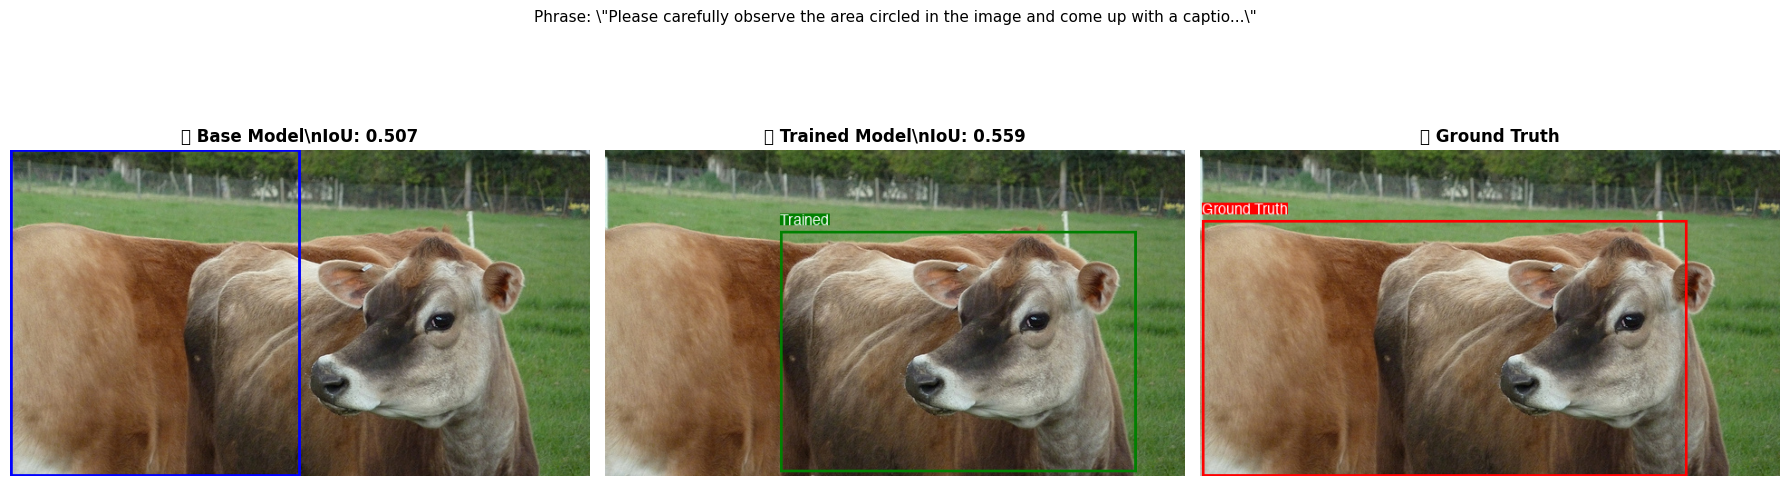

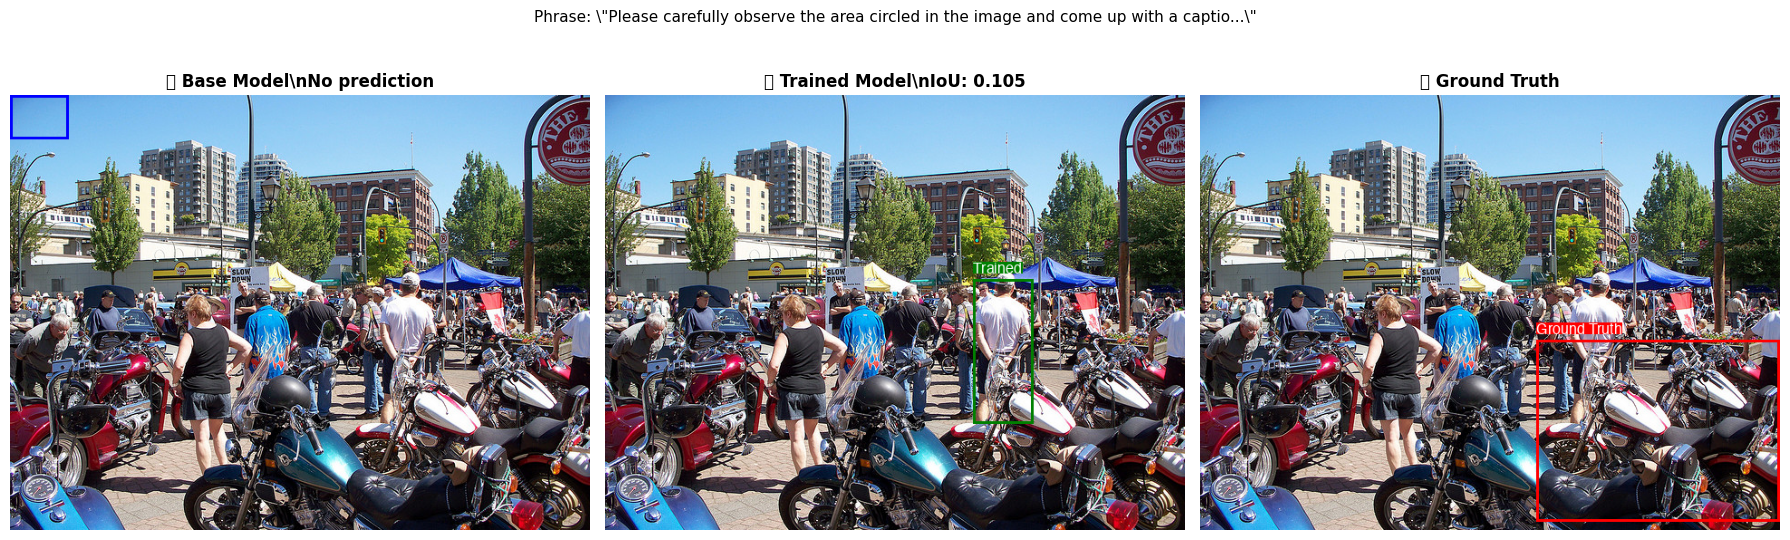

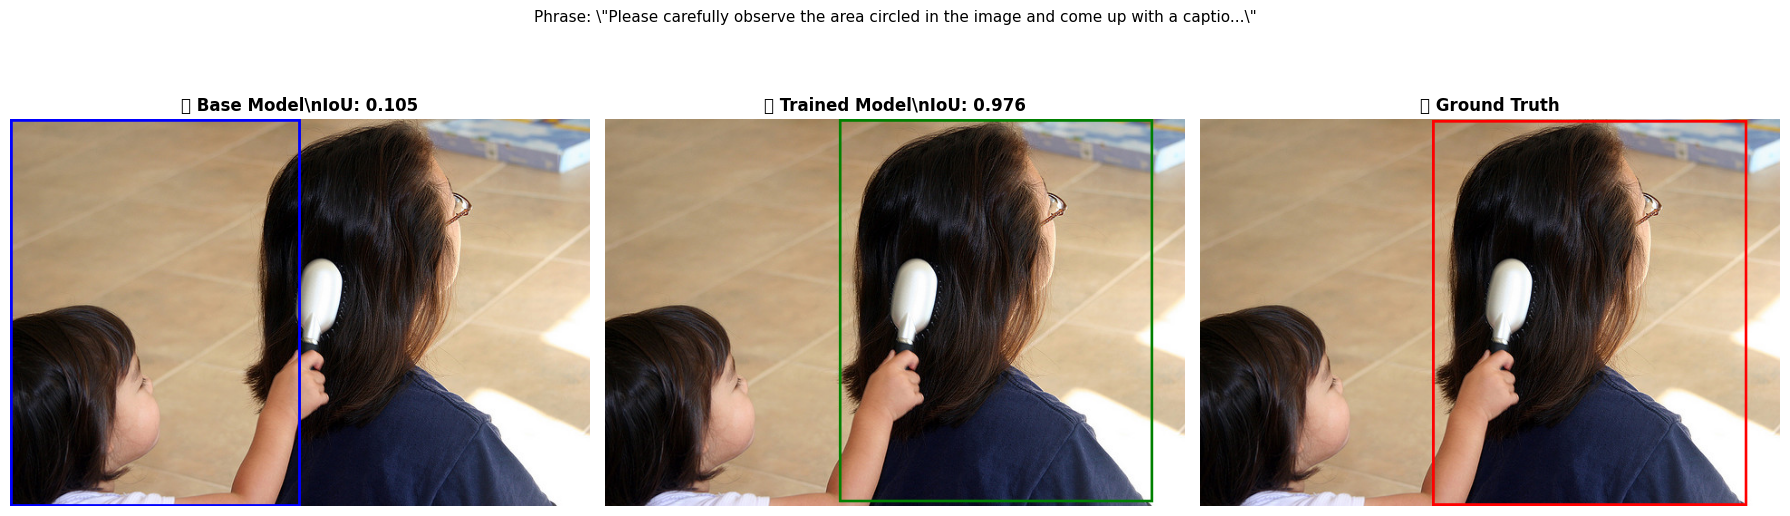


✓ Evaluation complete!


In [19]:
import matplotlib.pyplot as plt
from src.common.viz import draw_bbox_on_image

print("=" * 70)
print("EVALUATING TRAINED MODEL")
print("=" * 70)

# ============================================
# Run Inference on Trained Model
# ============================================
print(f"\n🟢 Running inference on {len(test_samples)} samples...")
trained_results = []

for sample in tqdm(test_samples, desc="Trained model inference"):
    result = predict_grounding_bbox(
        image=sample['image'],
        phrase=sample['phrase'],
        model=model,  # Your trained model
        processor=processor,
        device=str(device),
        visualize=False
    )
    
    # Calculate IoU if prediction succeeded
    iou = None
    if result['success'] and result['bbox_norm'] is not None:
        iou = calculate_iou(result['bbox_norm'], sample['ground_truth_bbox'])
    
    trained_results.append({
        'success': result['success'],
        'predicted_bbox': result['bbox_norm'],
        'iou': iou,
        'raw_response': result['raw_response']
    })

# ============================================
# Calculate Metrics
# ============================================
print("\n" + "=" * 70)
print("📊 TRAINED MODEL METRICS")
print("=" * 70)

# Detection rate
successful_predictions = sum(1 for r in trained_results if r['success'])
detection_rate = successful_predictions / len(trained_results) * 100

# IoU metrics (only for successful predictions)
ious = [r['iou'] for r in trained_results if r['iou'] is not None]
mean_iou = np.mean(ious) if ious else 0.0
median_iou = np.median(ious) if ious else 0.0

# Accuracy @ different thresholds
acc_at_50 = sum(1 for iou in ious if iou >= 0.5) / len(trained_results) * 100 if ious else 0.0
acc_at_75 = sum(1 for iou in ious if iou >= 0.75) / len(trained_results) * 100 if ious else 0.0

print(f"\n🎯 Detection Metrics:")
print(f"  Total samples:          {len(trained_results)}")
print(f"  Successful predictions: {successful_predictions}")
print(f"  Detection rate:         {detection_rate:.1f}%")

print(f"\n📏 IoU Metrics (for successful predictions):")
print(f"  Mean IoU:               {mean_iou:.4f}")
print(f"  Median IoU:             {median_iou:.4f}")

print(f"\n✅ Accuracy Metrics:")
print(f"  Accuracy@0.5:           {acc_at_50:.1f}% ({int(acc_at_50 * len(trained_results) / 100)}/{len(trained_results)})")
print(f"  Accuracy@0.75:          {acc_at_75:.1f}% ({int(acc_at_75 * len(trained_results) / 100)}/{len(trained_results)})")

# ============================================
# Comparison with Base Model
# ============================================
print("\n" + "=" * 70)
print("📈 IMPROVEMENT OVER BASE MODEL")
print("=" * 70)

print(f"\n🔄 Detection Rate:")
print(f"  Base:    {base_model_metrics['detection_rate']:.1f}%")
print(f"  Trained: {detection_rate:.1f}%")
print(f"  Change:  {detection_rate - base_model_metrics['detection_rate']:+.1f}%")

print(f"\n🔄 Mean IoU:")
print(f"  Base:    {base_model_metrics['mean_iou']:.4f}")
print(f"  Trained: {mean_iou:.4f}")
print(f"  Change:  {mean_iou - base_model_metrics['mean_iou']:+.4f}")

print(f"\n🔄 Accuracy@0.5:")
print(f"  Base:    {base_model_metrics['acc_at_50']:.1f}%")
print(f"  Trained: {acc_at_50:.1f}%")
print(f"  Change:  {acc_at_50 - base_model_metrics['acc_at_50']:+.1f}%")

print(f"\n🔄 Accuracy@0.75:")
print(f"  Base:    {base_model_metrics['acc_at_75']:.1f}%")
print(f"  Trained: {acc_at_75:.1f}%")
print(f"  Change:  {acc_at_75 - base_model_metrics['acc_at_75']:+.1f}%")

# Determine if training helped
if mean_iou > base_model_metrics['mean_iou']:
    print(f"\n🎉 Training improved mean IoU by {((mean_iou - base_model_metrics['mean_iou']) / base_model_metrics['mean_iou'] * 100):+.1f}%!")
elif mean_iou < base_model_metrics['mean_iou']:
    print(f"\n⚠️  Training decreased mean IoU (may need more epochs or different hyperparameters)")
else:
    print(f"\n➡️  No change in performance")

print("=" * 70)

# ============================================
# Visualize Sample Predictions
# ============================================
print("\n🎨 Visualizing sample predictions...")

# Show 3 random samples
num_viz_samples = min(3, len(test_samples))
viz_indices = random.sample(range(len(test_samples)), num_viz_samples)

for viz_idx in viz_indices:
    sample = test_samples[viz_idx]
    base_pred = base_model_metrics['results'][viz_idx]
    trained_pred = trained_results[viz_idx]
    
    # Create visualizations
    base_viz = sample['image'].copy()
    if base_pred['predicted_bbox']:
        base_viz = draw_bbox_on_image(base_viz, base_pred['predicted_bbox'], color='blue', width=3, label='Base')
    
    trained_viz = sample['image'].copy()
    if trained_pred['predicted_bbox']:
        trained_viz = draw_bbox_on_image(trained_viz, trained_pred['predicted_bbox'], color='green', width=3, label='Trained')
    
    gt_viz = draw_bbox_on_image(sample['image'].copy(), sample['ground_truth_bbox'], color='red', width=3, label='Ground Truth')
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(base_viz)
    axes[0].set_title(f"🔵 Base Model\\nIoU: {base_pred['iou']:.3f}" if base_pred['iou'] else "🔵 Base Model\\nNo prediction", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(trained_viz)
    axes[1].set_title(f"🟢 Trained Model\\nIoU: {trained_pred['iou']:.3f}" if trained_pred['iou'] else "🟢 Trained Model\\nNo prediction", fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(gt_viz)
    axes[2].set_title("🎯 Ground Truth", fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # Add phrase as title
    phrase_display = sample['phrase'][:80] + "..." if len(sample['phrase']) > 80 else sample['phrase']
    fig.suptitle(f"Phrase: \\\"{phrase_display}\\\"", fontsize=11, y=0.98)
    
    plt.tight_layout()
    plt.show()

print("\n✓ Evaluation complete!")
print("=" * 70)

## 11. Interactive Testing: Test Your Own Images

**Test both models on custom images and phrases.**

This cell lets you:
- Specify a custom image path
- Provide a referring expression/phrase
- See predictions from both base and trained models
- View bounding boxes and raw coordinates

In [ ]:
from PIL import Image
from pathlib import Path

# ============================================
# CUSTOMIZE THESE
# ============================================
# Option 1: Use a test sample from the dataset
USE_TEST_SAMPLE = True
TEST_SAMPLE_INDEX = 0  # Which test sample to use (0-19)

# Option 2: Use your own image
CUSTOM_IMAGE_PATH = "/path/to/your/image.jpg"  # Change this
CUSTOM_PHRASE = "the red car on the left"  # Change this

print("=" * 70)
print("INTERACTIVE TESTING")
print("=" * 70)

# Load image and phrase
if USE_TEST_SAMPLE:
    if TEST_SAMPLE_INDEX >= len(test_samples):
        print(f"❌ Error: TEST_SAMPLE_INDEX ({TEST_SAMPLE_INDEX}) out of range (0-{len(test_samples)-1})")
    else:
        test_image = test_samples[TEST_SAMPLE_INDEX]['image']
        test_phrase = test_samples[TEST_SAMPLE_INDEX]['phrase']
        ground_truth = test_samples[TEST_SAMPLE_INDEX]['ground_truth_bbox']
        print(f"\n📸 Using test sample #{TEST_SAMPLE_INDEX}")
        print(f"  Phrase: '{test_phrase[:70]}...'")
        print(f"  Ground truth bbox: {ground_truth}")
else:
    test_image = Image.open(CUSTOM_IMAGE_PATH).convert('RGB')
    test_phrase = CUSTOM_PHRASE
    ground_truth = None
    print(f"\n📸 Using custom image: {CUSTOM_IMAGE_PATH}")
    print(f"  Phrase: '{test_phrase}'")

# ============================================
# Run Predictions
# ============================================
print(f"\n🔵 Running BASE MODEL prediction...")
base_model_test, base_processor_test = load_qwen3_vl_with_lora(
    model_name="Qwen/Qwen3-VL-2B-Instruct",
    use_quantization=False,
    lora_r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    device=str(device)
)

base_pred = predict_grounding_bbox(
    image=test_image,
    phrase=test_phrase,
    model=base_model_test,
    processor=base_processor_test,
    device=str(device),
    visualize=False
)

print(f"✓ Base model prediction:")
if base_pred['success']:
    print(f"  Normalized bbox: {base_pred['bbox_norm']}")
    print(f"  Pixel bbox: {base_pred['bbox_px']}")
    if ground_truth:
        base_iou = calculate_iou(base_pred['bbox_norm'], ground_truth)
        print(f"  IoU: {base_iou:.4f}")
else:
    print(f"  ❌ Failed to predict")
print(f"  Raw response: {base_pred['raw_response'][:100]}...")

print(f"\n🟢 Running TRAINED MODEL prediction...")
trained_pred = predict_grounding_bbox(
    image=test_image,
    phrase=test_phrase,
    model=model,
    processor=processor,
    device=str(device),
    visualize=False
)

print(f"✓ Trained model prediction:")
if trained_pred['success']:
    print(f"  Normalized bbox: {trained_pred['bbox_norm']}")
    print(f"  Pixel bbox: {trained_pred['bbox_px']}")
    if ground_truth:
        trained_iou = calculate_iou(trained_pred['bbox_norm'], ground_truth)
        print(f"  IoU: {trained_iou:.4f}")
else:
    print(f"  ❌ Failed to predict")
print(f"  Raw response: {trained_pred['raw_response'][:100]}...")

# ============================================
# Visualize
# ============================================
print(f"\n🎨 Creating visualization...")

fig, axes = plt.subplots(1, 3 if ground_truth else 2, figsize=(18 if ground_truth else 12, 6))

# Base model
base_viz = test_image.copy()
if base_pred['success'] and base_pred['bbox_norm']:
    base_viz = draw_bbox_on_image(base_viz, base_pred['bbox_norm'], color='blue', width=3, label='Base')
axes[0].imshow(base_viz)
axes[0].set_title(f"🔵 Base Model" + (f"\\nIoU: {base_iou:.3f}" if base_pred['success'] and ground_truth else ""), 
                  fontsize=14, fontweight='bold')
axes[0].axis('off')

# Trained model
trained_viz = test_image.copy()
if trained_pred['success'] and trained_pred['bbox_norm']:
    trained_viz = draw_bbox_on_image(trained_viz, trained_pred['bbox_norm'], color='green', width=3, label='Trained')
axes[1].imshow(trained_viz)
axes[1].set_title(f"🟢 Trained Model" + (f"\\nIoU: {trained_iou:.3f}" if trained_pred['success'] and ground_truth else ""),
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Ground truth (if available)
if ground_truth:
    gt_viz = draw_bbox_on_image(test_image.copy(), ground_truth, color='red', width=3, label='Ground Truth')
    axes[2].imshow(gt_viz)
    axes[2].set_title("🎯 Ground Truth", fontsize=14, fontweight='bold')
    axes[2].axis('off')

phrase_display = test_phrase[:80] + "..." if len(test_phrase) > 80 else test_phrase
fig.suptitle(f"Phrase: \\\"{phrase_display}\\\"", fontsize=12, y=0.98)

plt.tight_layout()
plt.show()

print("=" * 70)

# Cleanup
del base_model_test, base_processor_test
gc.collect()
if device.type == "mps":
    torch.mps.empty_cache()
print("✓ Cleaned up base model from memory")

## Notes

### Training Tips
- Start with small `BATCH_SIZE` and `MAX_TRAIN_SAMPLES`
- Monitor system temperature during training
- Use gradient accumulation to simulate larger batches
- Checkpoints are automatically saved during training

### Output Locations
- Model checkpoints: `outputs/qwen3_refcoco/`
- Training logs: `logs/`
- LoRA weights: `outputs/qwen3_refcoco/final_lora_weights/`

### Resuming Training
To resume from a checkpoint, modify the trainer initialization to load from a saved checkpoint.